In [154]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [155]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

In [156]:
%matplotlib inline

In [157]:
df = pd.read_csv('/content/cleaned_data.csv')

In [158]:
df.shape

(150000, 53)

**User Engagement Analysis**

In [159]:
result_df = (
    df
    .groupby("MSISDN/Number")["Bearer Id"]
    .nunique()
    .reset_index(name="SessionFrequency")
    .rename(columns={"MSISDN/Number": "MSISDN"})
    .sort_values(by="SessionFrequency", ascending=False)
    .head(10)
)

# Display the resulting DataFrame
print(result_df)

             MSISDN  SessionFrequency
13526  3.362632e+10                 6
51874  3.366324e+10                 4
13008  3.362550e+10                 4
91062  3.375345e+10                 4
98661  3.376281e+10                 4
89046  3.369959e+10                 4
22793  3.364981e+10                 4
28994  3.365801e+10                 4
81620  3.368651e+10                 4
35542  3.365938e+10                 4


**Session duration per user**

In [160]:
result_df = (
    df
    .groupby("MSISDN/Number")["Dur. (ms)"]
    .sum()
    .reset_index(name="SessionDuration")
    .sort_values(by="SessionDuration", ascending=False)
    .head(10)
)

# Display the resulting DataFrame
print(result_df)

       MSISDN/Number  SessionDuration
13526   3.362632e+10       81238323.0
13180   3.362578e+10       18553754.0
6437    3.361489e+10        9966898.0
92923   3.376054e+10        9279434.0
65118   3.366716e+10        8744914.0
50281   3.366284e+10        6614270.0
57160   3.366469e+10        6288730.0
666     3.360313e+10        6287761.0
66029   3.366746e+10        5649882.0
92577   3.376041e+10        5321667.0


**Median of the sessions durations**

In [161]:
result_df = (
    df
    .groupby("MSISDN/Number")["Dur. (ms)"]
    .sum()
    .reset_index(name="SessionDuration")
    .sort_values(by="SessionDuration", ascending=False)
)
median_session_duration = result_df['SessionDuration'].median()
print(median_session_duration)

102740.0


**Total traffic per user**

In [162]:
result_df = (
    df
    .groupby("MSISDN/Number")
    .agg(
        TotalDownload=("Total DL (Bytes)", "sum"),
        TotalUpload=("Total UL (Bytes)", "sum")
    )
    .reset_index()
)
result_df["TotalTraffic"] = result_df["TotalDownload"] + result_df["TotalUpload"]
result_df = result_df.sort_values(by="TotalTraffic", ascending=False).head(10)
print(result_df)

       MSISDN/Number  TotalDownload   TotalUpload  TotalTraffic
13526   3.362632e+10   4.942252e+11  4.499495e+10  5.392201e+11
6437    3.361489e+10   8.156743e+09  6.894830e+08  8.846226e+09
92923   3.376054e+10   7.811295e+09  7.034786e+08  8.514774e+09
13180   3.362578e+10   7.770043e+09  7.295774e+08  8.499621e+09
76363   3.367588e+10   7.309542e+09  5.815688e+08  7.891111e+09
37052   3.365973e+10   7.081602e+09  6.242603e+08  7.705863e+09
63028   3.366646e+10   6.903440e+09  4.050610e+08  7.308501e+09
92577   3.376041e+10   6.610852e+09  5.215189e+08  7.132371e+09
57241   3.366471e+10   6.400774e+09  4.712445e+08  6.872018e+09
86455   3.369879e+10   6.010556e+09  5.303431e+08  6.540899e+09


**Median Total traffic of user**

In [163]:
result_df = (
    df
    .groupby("MSISDN/Number")
    .agg(
        TotalDownload=("Total DL (Bytes)", "sum"),
        TotalUpload=("Total UL (Bytes)", "sum")
    )
    .reset_index()
)
result_df["TotalTraffic"] = result_df["TotalDownload"] + result_df["TotalUpload"]  # Calculate TotalTraffic after aggregation
result_df = result_df.sort_values(by="TotalTraffic", ascending=False)
median_total_traffic = result_df['TotalTraffic'].median()
print(median_total_traffic)

617923138.0


**Aggregating engagement metrics**

In [164]:
aggregated_df = (
    df
    .groupby("MSISDN/Number")
    .agg(
        SessionDuration=("Dur. (ms)", "sum"),
        SessionFrequency=("Bearer Id", "nunique"),
        TotalDownload=("Total DL (Bytes)", "sum"),  # Separate aggregation for download
        TotalUpload=("Total UL (Bytes)", "sum")    # Separate aggregation for upload
    )
    .reset_index()
)

# Calculate the TotalTraffic after the individual aggregations
aggregated_df["TotalTraffic"] = aggregated_df["TotalDownload"] + aggregated_df["TotalUpload"]

# Display the last few rows of the resulting DataFrame
print(aggregated_df.tail())


        MSISDN/Number  SessionDuration  SessionFrequency  TotalDownload  \
106851   3.379000e+10           8810.0                 1    687925212.0   
106852   3.379000e+10         140988.0                 1    444575092.0   
106853   3.197020e+12         877385.0                 1    194828056.0   
106854   3.370000e+14         253030.0                 1    539634985.0   
106855   8.823970e+14         869844.0                 1     78697597.0   

        TotalUpload  TotalTraffic  
106851   26716429.0   714641641.0  
106852   35732243.0   480307335.0  
106853   37295915.0   232123971.0  
106854   56652839.0   596287824.0  
106855   60456049.0   139153646.0  


**handle outliers**

In [165]:
def handle_outliers(df, columns, threshold=3):
    for column in columns:
        z_scores = np.abs((df[column] - np.mean(df[column])) / np.std(df[column]))
        outliers = z_scores > threshold
        df.loc[outliers, column] = np.median(df[column])
    return df

In [166]:
columns_to_handle = ["SessionDuration", "SessionFrequency", "TotalTraffic"]
aggregated_df = handle_outliers(aggregated_df, columns_to_handle)
print(aggregated_df)

        MSISDN/Number  SessionDuration  SessionFrequency  TotalDownload  \
0        3.360100e+10         116720.0                 1   8.426375e+08   
1        3.360100e+10         181230.0                 1   1.207552e+08   
2        3.360100e+10         134969.0                 1   5.566597e+08   
3        3.360101e+10          49878.0                 1   4.019932e+08   
4        3.360101e+10          37104.0                 2   1.363130e+09   
...               ...              ...               ...            ...   
106851   3.379000e+10           8810.0                 1   6.879252e+08   
106852   3.379000e+10         140988.0                 1   4.445751e+08   
106853   3.197020e+12         877385.0                 1   1.948281e+08   
106854   3.370000e+14         253030.0                 1   5.396350e+08   
106855   8.823970e+14         869844.0                 1   7.869760e+07   

        TotalUpload  TotalTraffic  
0        36053108.0  8.786906e+08  
1        36104459.0  1.5685

**Normalize engagement metrics**

In [167]:
scaler = MinMaxScaler()
columns_to_normalize = ["SessionDuration", "SessionFrequency","TotalTraffic"]
customer_id = aggregated_df['MSISDN/Number']
transformed_data = scaler.fit_transform(aggregated_df[columns_to_normalize])
normalized_data = pd.DataFrame(transformed_data, columns=columns_to_normalize)
df_normalized = pd.concat([customer_id, normalized_data], axis=1)
df_normalized

,MSISDN/Number,SessionDuration,SessionFrequency,TotalTraffic
0,3.360100e+10,0.102756,0.0,0.147766
1,3.360100e+10,0.163249,0.0,0.021605
2,3.360100e+10,0.119868,0.0,0.098352
3,3.360101e+10,0.040075,0.0,0.068002
4,3.360101e+10,0.028097,1.0,0.248915
...,...,...,...,...
106851,3.379000e+10,0.001564,0.0,0.119094
106852,3.379000e+10,0.125513,0.0,0.078137
106853,3.197020e+12,0.816061,0.0,0.034759
106854,3.370000e+14,0.230579,0.0,0.098408


**K-means clustering with k = 3**

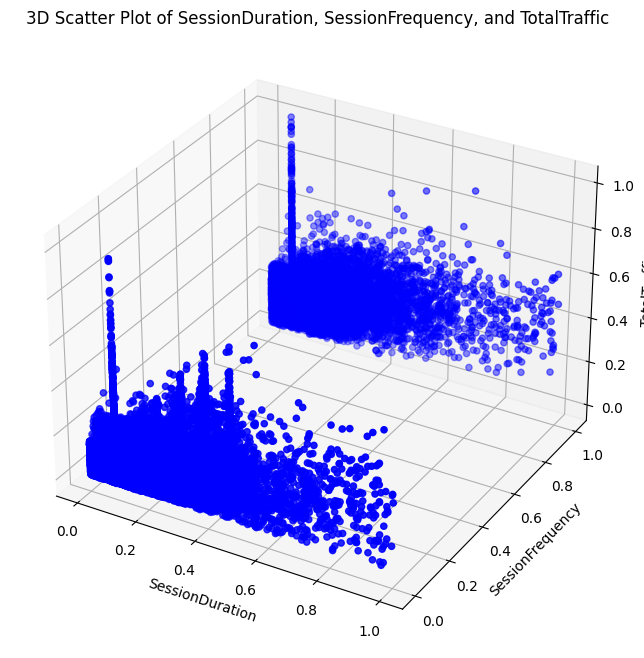

In [168]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df_normalized['SessionDuration'], df_normalized['SessionFrequency'], df_normalized['TotalTraffic'], c='blue', marker='o')

ax.set_xlabel('SessionDuration')
ax.set_ylabel('SessionFrequency')


ax.set_zlabel('TotalTraffic')

plt.title('3D Scatter Plot of SessionDuration, SessionFrequency, and TotalTraffic')
plt.show()

In [169]:
selected_columns = columns_to_normalize
X = df_normalized[selected_columns]
k = 3

kmeans = KMeans(n_clusters=3, random_state=0, n_init=25)
kmeans.fit(X)

df_normalized['Cluster'] = kmeans.labels_

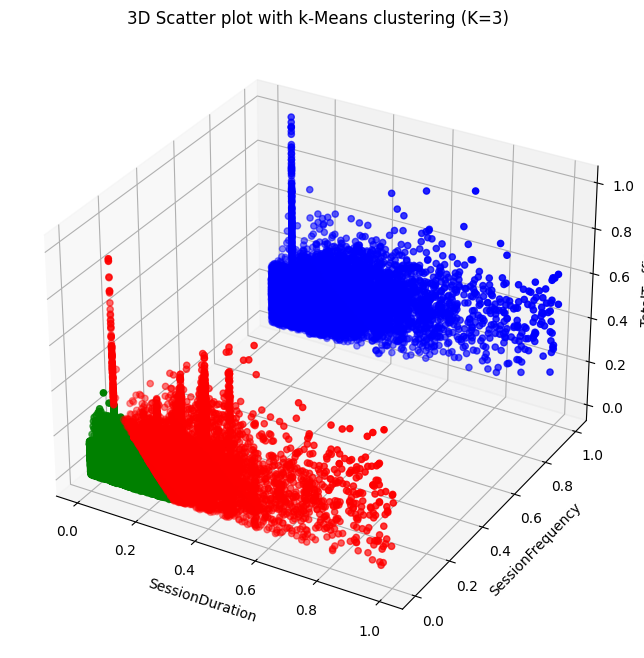

In [170]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

cluster_colors = {0: 'red', 1: 'blue', 2:'green'}

for cluster_label, color in cluster_colors.items():
    cluster_data = df_normalized[df_normalized['Cluster'] == cluster_label]
    ax.scatter(
        cluster_data['SessionDuration'],
        cluster_data['SessionFrequency'],
        cluster_data['TotalTraffic'],
        label=f'Cluster {cluster_label}',
        color=color
        )

ax.set_xlabel('SessionDuration')
ax.set_ylabel('SessionFrequency')
ax.set_zlabel('TotalTraffic')

plt.title(f'3D Scatter plot with k-Means clustering (K={k})')
plt.show()

**Minimum, Maximum, average and total in each cluster**

In [171]:
grouped_df = (df_normalized
                .groupby('Cluster')[["SessionDuration", "SessionFrequency", "TotalTraffic"]]
                .agg(['min', 'max', 'mean', 'sum']))

grouped_df

SessionDuration                                  SessionFrequency  \
                    min       max      mean          sum              min   
Cluster                                                                     
0              0.089646  1.000000  0.318565  3503.259492              0.0   
1              0.013482  0.999179  0.172924  2749.840692              1.0   
2              0.000000  0.276607  0.086646  6927.947648              0.0   

                           TotalTraffic                                   
         max mean      sum          min       max      mean          sum  
Cluster                                                                   
0        0.0  0.0      0.0     0.003300  0.987289  0.212534  2337.237019  
1        1.0  1.0  15902.0     0.020113  1.000000  0.199900  3178.813828  
2        0.0  0.0      0.0     0.000000  0.394050  0.084461  6753.217869

**Grouping users in k engagement clusters using elbow method**

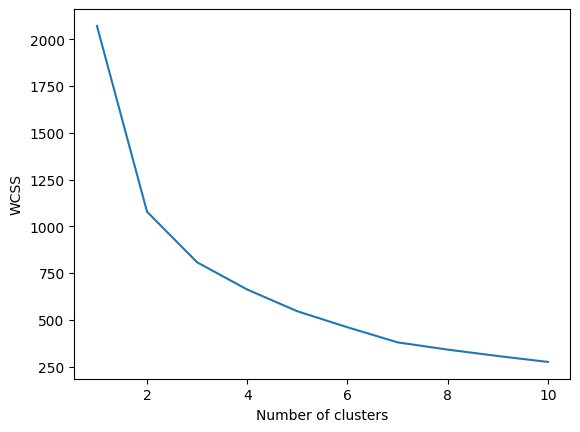

In [172]:
wcss = []
X = df_normalized.iloc[:, [1, 3]]

for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, random_state=42, n_init=10)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

The ideal value for K in the engagement analysis remains consistent at K = 7

**KMeans for k = 7**

In [173]:
selected_columns = columns_to_normalize
X = df_normalized[selected_columns]
k = 7

kmeans = KMeans(n_clusters=k, random_state=0, n_init=25)
kmeans.fit(X)

df_normalized['Cluster'] = kmeans.labels_

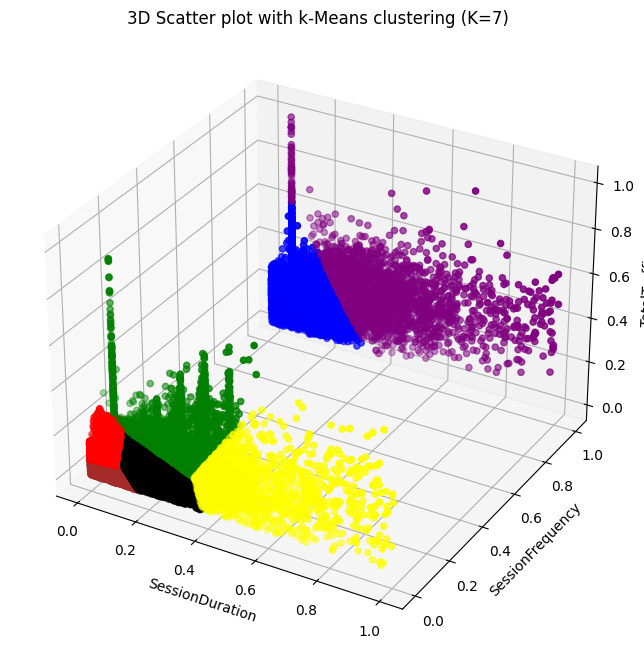

In [174]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

cluster_colors = {0: 'red', 1: 'blue', 2:'green', 3:'black', 4:'yellow', 5:'brown', 6:'purple'}

for cluster_label, color in cluster_colors.items():
    cluster_data = df_normalized[df_normalized['Cluster'] == cluster_label]
    ax.scatter(
        cluster_data['SessionDuration'],
        cluster_data['SessionFrequency'],
        cluster_data['TotalTraffic'],
        label=f'Cluster {cluster_label}',
        color=color
        )

ax.set_xlabel('SessionDuration')
ax.set_ylabel('SessionFrequency')
ax.set_zlabel('TotalTraffic')

plt.title(f'3D Scatter plot with k-Means clustering (K={k})')
plt.show()

In [175]:
df_normalized.to_csv('normalized_data.csv', index=False)


In [176]:
df_normalized.shape

(106856, 5)

**Aggregate user total traffic per application**

In [177]:
user_app_df = (
    df
    .groupby("MSISDN/Number")
    .agg(
        Total_Youtube_Traffic=("Youtube DL (Bytes)", "sum"), # Check for typos in column names
        Total_Youtube_Traffic_UL=("Youtube UL (Bytes)", "sum"),
        Total_Netflix_Traffic=("Netflix DL (Bytes)", "sum"),
        Total_Netflix_Traffic_UL=("Netflix UL (Bytes)", "sum"),
        Total_Google_Traffic=("Google DL (Bytes)", "sum"),
        Total_Google_Traffic_UL=("Google UL (Bytes)", "sum"),
        Total_Email_Traffic=("Email DL (Bytes)", "sum"),
        Total_Email_Traffic_UL=("Email UL (Bytes)", "sum")
    )
    .reset_index()
    .rename(columns={"MSISDN/Number": "User_MSISDN"})
)

In [178]:
user_app_df['Total_Youtube_Traffic'] = user_app_df['Total_Youtube_Traffic'] + user_app_df['Total_Youtube_Traffic_UL']
user_app_df['Total_Netflix_Traffic'] = user_app_df['Total_Netflix_Traffic'] + user_app_df['Total_Netflix_Traffic_UL']
user_app_df['Total_Google_Traffic'] = user_app_df['Total_Google_Traffic'] + user_app_df['Total_Google_Traffic_UL']
user_app_df['Total_Email_Traffic'] = user_app_df['Total_Email_Traffic'] + user_app_df['Total_Email_Traffic_UL']


In [179]:
user_app_df.drop(['Total_Youtube_Traffic_UL', 'Total_Netflix_Traffic_UL', 'Total_Google_Traffic_UL', 'Total_Email_Traffic_UL'], axis=1, inplace=True)


In [180]:
print(user_app_df.head())

    User_MSISDN  Total_Youtube_Traffic  Total_Netflix_Traffic  \
0  3.360100e+10             21624548.0             27180981.0   
1  3.360100e+10             12432223.0             11221763.0   
2  3.360100e+10             21333570.0             19353900.0   
3  3.360101e+10              6977321.0              1942092.0   
4  3.360101e+10             41533002.0             49201724.0   

   Total_Google_Traffic  Total_Email_Traffic  
0             4389005.0            1331362.0  
1             5334863.0            3307781.0  
2             3443126.0            3205380.0  
3             9678493.0            2284670.0  
4            18499616.0            3305469.0  


**Top 10 engaged users**

In [181]:
print(user_app_df.columns)

Index(['User_MSISDN', 'Total_Youtube_Traffic', 'Total_Netflix_Traffic',
       'Total_Google_Traffic', 'Total_Email_Traffic'],
      dtype='object')


In [182]:
agg_by_netflix = user_app_df[['Total_Netflix_Traffic']].groupby(user_app_df['User_MSISDN']).mean()
agg_by_netflix.sort_values(by = 'Total_Netflix_Traffic', ascending = False).head(10)


,Total_Netflix_Traffic
User_MSISDN,
3.362632e+10,2.455967e+10
3.365973e+10,3.995191e+08
3.361489e+10,3.614010e+08
3.362578e+10,3.569806e+08
3.376054e+10,3.346433e+08
3.376041e+10,3.183475e+08
3.366716e+10,3.139395e+08
3.367588e+10,3.090932e+08
3.378632e+10,3.059398e+08


In [183]:
agg_by_youtube = user_app_df[['Total_Youtube_Traffic']].groupby(user_app_df['User_MSISDN']).mean()
agg_by_youtube.sort_values(by = 'Total_Youtube_Traffic', ascending = False).head(10)

,Total_Youtube_Traffic
User_MSISDN,
3.362632e+10,2.469257e+10
3.362578e+10,4.529588e+08
3.376054e+10,3.962892e+08
3.361489e+10,3.943702e+08
3.367588e+10,3.174106e+08
3.366716e+10,3.152313e+08
3.362708e+10,3.087908e+08
3.376041e+10,3.031691e+08
3.369879e+10,3.026620e+08


In [184]:
agg_by_google = user_app_df[['Total_Google_Traffic']].groupby(user_app_df['User_MSISDN']).mean()
agg_by_google.sort_values(by = 'Total_Google_Traffic', ascending = False).head(10)

,Total_Google_Traffic
User_MSISDN,
3.362632e+10,8.392961e+09
3.362578e+10,1.423079e+08
3.361489e+10,1.279738e+08
3.376054e+10,1.232231e+08
3.365973e+10,1.165163e+08
3.378632e+10,1.102545e+08
3.367588e+10,1.098605e+08
3.366716e+10,1.050327e+08
3.376127e+10,9.708999e+07


In [185]:
agg_by_email = user_app_df[['Total_Email_Traffic']].groupby(user_app_df['User_MSISDN']).mean()
agg_by_email.sort_values(by = 'Total_Email_Traffic', ascending = False).head(10)

,Total_Email_Traffic
User_MSISDN,
3.362632e+10,2.440040e+09
3.361489e+10,4.078863e+07
3.362578e+10,4.063397e+07
3.378632e+10,3.631012e+07
3.365973e+10,3.599979e+07
3.376054e+10,3.369377e+07
3.367588e+10,3.151442e+07
3.366546e+10,3.041788e+07
3.366716e+10,3.033580e+07


**Most used applications**

In [194]:
sum_email = user_app_df['Total_Email_Traffic'].sum()
sum_netflix = user_app_df['Total_Netflix_Traffic'].sum()
sum_google = user_app_df['Total_Google_Traffic'].sum()
sum_youtube = user_app_df['Total_Youtube_Traffic'].sum()

In [195]:
data = {
    'Traffic_Type': ['Total_Email_Traffic', 'Total_Netflix_Traffic', 'Total_Google_Traffic', 'Total_Youtube_Traffic'],
    'Total_Traffic': [sum_email, sum_netflix, sum_google, sum_youtube]
}
traffic_summary_df = pd.DataFrame(data)
traffic_summary_df

,Traffic_Type,Total_Traffic
0,Total_Email_Traffic,3.388653e+11
1,Total_Netflix_Traffic,3.394291e+12
2,Total_Google_Traffic,1.171094e+12
3,Total_Youtube_Traffic,3.396522e+12


The top used apps are Youtube, Netflix and Google

**Plot of top 3 used applications**

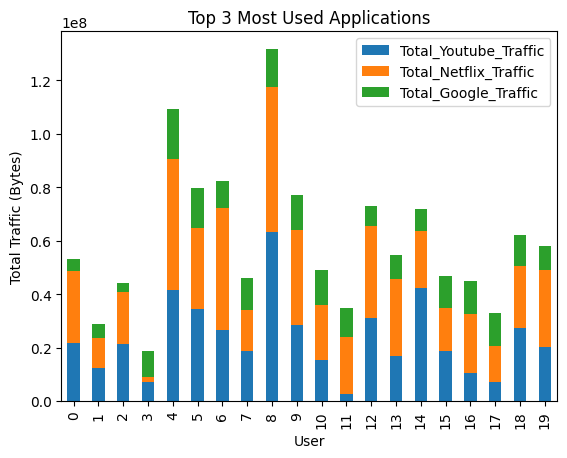

In [199]:
top_3_apps = user_app_df[['Total_Youtube_Traffic', 'Total_Netflix_Traffic', 'Total_Google_Traffic']].head(20)

top_3_apps.plot(kind='bar', stacked=True)
plt.title('Top 3 Most Used Applications')
plt.xlabel('User')
plt.ylabel('Total Traffic (Bytes)')
plt.show()

In [200]:
df_normalized.to_csv('normalized_data.csv', index=False)

In [203]:
df_normalized.shape

(106856, 5)